# SageMaker Endpoint (Single Model Endpoint)
---

이제 **SageMaker 모델 호스팅 서비스인 SageMaker 엔드포인트**에 모델을 배포할 준비가 되었습니다. 

SageMaker 엔드포인트는 REST API를 통해 실시간 추론을 수행할 수 있는 완전 관리형 서비스입니다. 기본적으로 분산 컨테이너로 고가용성, 다중 모델 로딩, A/B 테스트를 위한 인프라 환경(EC2, 로드밸런서, 오토스케일링, 모델 아티팩트 로딩 등)이 사전 구축되어 있기에 몇 줄의 코드만으로 Endpoint가 자동으로 생성되기에, 모델을 프로덕션에 빠르게 배포할 수 있습니다.

SageMaker 빌트인 XGBoost를 사용하면 별도의 훈련/추론 스크립트 작성 없이 쉽게 모델을 훈련하고 엔드포인트로 배포할 수 있습니다. 하지만, 여러 가지 요인들로 인해 (예: SHAP 계산을 위한 피쳐 기여값 리턴, 추론값 및 추론 스코어 동시 리턴 등) 커스텀 추론 로직이 필요한 경우, SageMaker 빌트인 XGBoost 대신 SageMaker XGBoost 컨테이너를 사용할 수 있습니다.

이 노트북은 SageMaker XGBoost 컨테이너 상에서, 기본적인 추론 스크립트로 모델을 배포하는 법을 아래와 같은 목차로 진행합니다. 

완료 시간은 **20-30분** 정도 소요됩니다.

### 목차
- [1. Create Model Serving Script](#1.-Create-Model-Serving-Script)
- [2. Deploy a trained model from Amazon S3](#2.-Deploy-a-trained-model-from-Amazon-S3)
    - [2.1. Deploy to Local Environment: XGBoostModel class](#2.1.-Deploy-to-Local-Environment:-XGBoostModel-class)
    - [2.2. Deploy to Local Environment: Model class](#2.2.-Deploy-to-Local-Environment:-Model-class)
    - [2.3. Deploy to Hosting Instance](#2.3.-Deploy-to-Hosting-Instance)

유사한 예제로 실습해 보실 분들은 아래 링크의 샘플 노트북을 참조해 주세요.
- https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone_dist_script_mode.ipynb

<div class="alert alert-warning"><h4>주의</h4><p>
아래 코드 셀은 핸즈온에 필요한 라이브러리들을 설치하고, 주피터 노트북 커널을 셧다운시킵니다. 
    
노트북 커널이 셧다운된다면, 아래 코드 셀에서 <b><font color='darkred'>install_needed = False</font></b>로 변경 후, 코드 셀을 다시 실행해 주세요. 이 작업은 한 번만 수행하면 됩니다. 
</p></div>

In [1]:
import sys, IPython

install_needed = True
#install_needed = False

if install_needed:
    print("===> Installing deps and restarting kernel. Please change 'install_needed = False' and run this code cell again.")
    !{sys.executable} -m pip install -U sagemaker locust pyngrok xgboost==1.7.1
    IPython.Application.instance().kernel.do_shutdown(True)
else:
    import sagemaker, xgboost
    print(f'SageMaker API version={sagemaker.__version__}, XGBoost version={xgboost.__version__}')

===> Installing deps and restarting kernel. Please change 'install_needed = False' and run this code cell again.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 133.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 151.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 165.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 150.4 MB/s eta 0:00:00
  Attempting uninstall: gevent
    Found existing installation: gevent 25.4.1
    Uninstalling gevent-25.4.1:
      Successfully uninstalled gevent-25.4.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.243.3
    Uninstalling sagemaker-2.243.3:
      Successfully uninstalled sagemaker-2.243.3


In [5]:
import sagemaker

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/28/25 07:06:55] INFO     Found credentials from IAM Role:                                   ]8;id=316647;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=278158;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
sagemaker.__version__

'2.244.2'

In [7]:
%load_ext autoreload
%autoreload 2
%store -r
XGB_FRAMEWORK_VERSION = '1.7-1'
DATASET_PATH = '../data/dataset'

<br>

# 0. (Optional) Prepare Your Model
---

혹시 이전 과정을 다 끝내지 못했다면, 아래 코드 셀의 주석을 해제하여 코드 셀을 실행해 주세요.

In [8]:
%store -r
print(f"model_dir : {model_dir}")

model_dir : s3://sagemaker-us-east-1-992382423459/xgboost/output/sagemaker-xgboost-2025-05-28-03-28-18-601/output/model.tar.gz


In [17]:
!rm -rf model && mkdir model
!aws s3 cp $model_dir ./model
!tar -xzvf ./model/model.tar.gz -C ./model

download: s3://sagemaker-us-east-1-992382423459/xgboost/output/sagemaker-xgboost-2025-05-28-03-28-18-601/output/model.tar.gz to model/model.tar.gz
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
xgboost-model
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model.pkl


In [18]:
# import pandas as pd
# import xgboost as xgb
# data = pd.read_csv(f'{DATASET_PATH}/train.csv')
# train = data.drop('fraud', axis=1)
# label = pd.DataFrame(data['fraud'])
# dtrain = xgb.DMatrix(train, label=label)

# params = {'max_depth': 3, 'eta': 0.2, 'objective': "binary:logistic", 'scale_pos_weight': 29}
# num_boost_round = 100
# nfold = 5
# early_stopping_rounds = 10

# cv_results = xgb.cv(
#     params = params,
#     dtrain = dtrain,
#     num_boost_round = num_boost_round,
#     nfold = nfold,
#     early_stopping_rounds = early_stopping_rounds,
#     metrics = ('auc'),
#     stratified = True, # 레이블 (0,1) 의 분포에 따라 훈련 , 검증 세트 분리
#     seed = 0
# )

# print("cv_results: ", cv_results)

# # Select the best score
# print(f"[0]#011train-auc:{cv_results.iloc[-1]['train-auc-mean']}")
# print(f"[1]#011validation-auc:{cv_results.iloc[-1]['test-auc-mean']}")

# metrics_data = {
#     'classification_metrics': {
#         'validation:auc': { 'value': cv_results.iloc[-1]['test-auc-mean']},
#         'train:auc': {'value': cv_results.iloc[-1]['train-auc-mean']}
#     }
# }
      
# model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
# model.save_model("model/xgboost-model")
# !cd model && tar -czvf model.tar.gz xgboost-model && mv model.tar.gz ../

`Session()`은 AWS 환경에 접속하는 접속 정보와 SageMaker에서 사용하는 리소스를 관리하기 위한 편리한 방법을 제공합니다. 

In [19]:
import boto3
import sagemaker
import json

sess = sagemaker.Session()
sm_session = sagemaker.session.Session()
boto_session = boto3.session.Session()
sm_client = boto3.client("sagemaker")
bucket = sm_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto_session.region_name

print((bucket, role))

('sagemaker-us-east-1-992382423459', 'arn:aws:iam::992382423459:role/amazon-sagemaker-base-executionrole')


### Check Inference Results & Debugging

로컬 엔드포인트나 호스팅 엔드포인트 배포 전, 로컬 환경 상에서 직접 추론을 수행하여 결과를 확인합니다. 

In [20]:
import xgboost as xgb
import numpy as np
import pandas as pd

model = xgb.Booster()
model.load_model("model/xgboost-model")

test_df = pd.read_csv(f'{DATASET_PATH}/test.csv')
y_test = test_df.iloc[:, 0].astype('int')
test_df = test_df.drop('fraud', axis=1)
dtest = xgb.DMatrix(test_df)

In [21]:
y_prob = model.predict(dtest)
y_pred = np.array([1 if e >= 0.5 else 0 for e in y_prob])
y_prob[0], y_pred[0]

(0.10092484, 0)

<br>

# 1. Create Model Serving Script

---

아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [22]:
!sudo rm -rf src && mkdir src

In [23]:
%%writefile src/inference.py
import os
import time
import json
import pickle as pkl
import numpy as np
from io import BytesIO
import xgboost as xgb
import sagemaker_xgboost_container.encoder as xgb_encoders
NUM_FEATURES = 58


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    print("--------------- model_fn Start ---------------")
    model_file = "xgboost-model"
    model = xgb.Booster()
    model.load_model(os.path.join(model_dir, model_file))
    print("--------------- model_fn End ---------------")
    return model
                     

def input_fn(request_body, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.
    Return a DMatrix (an object that can be passed to predict_fn).
    """
    print("Content type: ", request_content_type)
    if request_content_type == "application/x-npy":        
        stream = BytesIO(request_body)
        array = np.frombuffer(stream.getvalue())
        array = array.reshape(int(len(array)/NUM_FEATURES), NUM_FEATURES)
        return xgb.DMatrix(array)
    elif request_content_type == "text/csv":
        return xgb_encoders.csv_to_dmatrix(request_body.rstrip("\n"))
    elif request_content_type == "text/libsvm":
        return xgb_encoders.libsvm_to_dmatrix(request_body)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )
        

def predict_fn(input_data, model):
    """
    SageMaker XGBoost model server invokes `predict_fn` on the return value of `input_fn`.

    Return a two-dimensional NumPy array (predictions and scores)
    """
    start_time = time.time()
    y_probs = model.predict(input_data)
    print("--- Inference time: %s secs ---" % (time.time() - start_time))    
    y_preds = [1 if e >= 0.5 else 0 for e in y_probs] 
    #feature_contribs = model.predict(input_data, pred_contribs=True, validate_features=False)
    return np.vstack((y_preds, y_probs))


def output_fn(predictions, content_type="application/json"):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    if content_type == "text/csv":
        return ','.join(str(x) for x in outputs)
    elif content_type == "application/json":
        outputs = json.dumps({
            'pred': predictions[0,:].tolist(),
            'prob': predictions[1,:].tolist()
        })        
        
        return outputs
    else:
        raise ValueError("Content type {} is not supported.".format(content_type))

Writing src/inference.py


<br>

# 2. Deploy a trained model from Amazon S3
---

SageMaker API의 `Model` 클래스는 훈련한 모델을 서빙하기 위한 모델 아티팩트와 도커 이미지를 정의합니다. 
`Model` 클래스 인스턴스 호출 시 AWS에서 사전 빌드한 도커 이미지 URL을 직접 가져올 수도 있지만, Model의 자식 클래스로(예: `XGBoostModel`, `TensorFlowModel`) 초기화하면 파라메터에 버전만 지정하는 것만으로 편리하게 추론을 수행하는 환경을 정의할 수 있습니다.

### Upload model/source artifacts to S3
압축한 모델 아티팩트를 Amazon S3로 복사합니다.

In [25]:
prefix = 'sm-special-webinar/deploy'
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'
# !cd model && tar -czvf model.tar.gz xgboost-model && mv model.tar.gz ../
!aws s3 cp ./model/model.tar.gz {s3_model_path}

upload: model/model.tar.gz to s3://sagemaker-us-east-1-992382423459/sm-special-webinar/deploy/model.tar.gz


<br>

## 2.1. Deploy to Local Environment: XGBoostModel class

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.

https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

```python
local_model_path = f'{os.getcwd()}/model'
ecr_uri = xgb_image_uri

# 도커 컨테이너 구동
!docker run --name xgb -itd -p 8080:8080 -v {local_model_path}:/opt/ml/model {ecr_uri} serve

# 실시간 호출 테스트 
!curl -X POST -H 'Content-Type: application/json' localhost:8080/invocations -d ...

# 도커 컨테이너 중지 및 삭제    
!docker stop xgb
!docker rm xgb
```

참고로 SageMaker SDK에서 `deploy(...)` 메소드로 엔드포인트 배포 시, 인스턴스 타입을 local 이나 local_gpu로 지정하면 위의 과정을 자동으로 수행할 수 있습니다.

```python
# 로컬 엔드포인트 배포
local_predictor = local_model.deploy(initial_instance_count=1, instance_type="local")

# 실시간 호출 테스트 
local_predictor.predict(...)

# 로컬 엔드포인트 삭제 (도커 컨테이너 중지 및 삭제)
local_predictor.delete_endpoint()
```

아래 코드를 보시면 아시겠지만, 지속적으로 업데이트되는 파이썬 버전&프레임워크 버전&트랜스포머 버전에 쉽게 대응할 수 있습니다. AWS에서 관리하고 있는 딥러닝 컨테이너(DLC) 목록을 아래 주소에서 확인해 보세요.
- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

### Create Model

In [26]:
instance_type='local'

In [27]:
from pathlib import Path

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    model_data=f"file://{Path.cwd()}/model"
else:
    sagemaker_session = sagemaker.session.Session()
    model_data=s3_model_path

[05/28/25 07:11:51] INFO     Found credentials from IAM Role:                                   ]8;id=664464;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=924772;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [28]:
from sagemaker.xgboost.model import XGBoostModel
from sagemaker.model import Model

xgb_model = XGBoostModel(
    model_data=model_data,
    source_dir="src",
    role=role,
    entry_point="inference.py",
    framework_version=XGB_FRAMEWORK_VERSION,
    sagemaker_session=sagemaker_session,
    # env={'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '600'}
)

### Create Endpoint

SageMaker SDK는 `deploy(...)` 메소드를 호출 시, `create-endpoint-config`와 `create-endpoint`를 같이 수행합니다. 좀 더 세분화된 파라메터 조정을 원하면 AWS CLI나 boto3 SDK client 활용을 권장 드립니다.

In [29]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

[05/28/25 07:11:52] INFO     Ignoring unnecessary instance type: local.                           ]8;id=729321;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=3501;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

[05/28/25 07:11:53] INFO     Creating model with name: sagemaker-xgboost-2025-05-28-07-11-53-104    ]8;id=161277;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=797535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4105\4105]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=13080;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=944288;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating endpoint-config with name                                     ]8;id=637444;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=427417;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6030\6030]8;;\
                             sagemaker-xgboost-2025-05-28-07-11-53-177                                             

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=54780;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=957542;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-05-28-07-11-53-177  ]8;id=822311;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=56560;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4852\4852]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=148257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=856064;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     'Docker Compose' is not installed. Proceeding to check for                ]8;id=12523;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=302205;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#162\162]8;;\
                             'docker-compose' CLI.                                                                 

                    INFO     'Docker Compose' found using Docker Compose CLI.                          ]8;id=751851;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=441643;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#173\173]8;;\

                    INFO     serving                                                                   ]8;id=16973;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=83411;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#338\338]8;;\

                    INFO     creating hosting dir in /tmp/tmplgoea5_8                                  ]8;id=468233;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=899019;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#341\341]8;;\

Login Succeeded


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



                    INFO     docker command: docker pull                                              ]8;id=584437;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=853504;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#1236\1236]8;;\
                             683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1                  

[05/28/25 07:13:06] INFO     image pulled:                                                            ]8;id=772647;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=454067;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#1239\1239]8;;\
                             683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1                  

                    INFO     Found credentials from IAM Role:                                   ]8;id=358460;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=390131;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     No AWS credentials found in session but credentials from EC2 Metadata    ]8;id=35754;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=329063;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#1141\1141]8;;\
                             Service are available.                                                                

                    INFO     docker compose file:                                                      ]8;id=544655;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=788343;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#781\781]8;;\
                             networks:                                                                             
                               sagemaker-local:                                                                    
                                 name: sagemaker-local                                                             
                             services:                                                                             
                               algo-1-g8qif:                                                                       
                                 command: serve                                                                    
                                 container_name: b3zft27bnt-algo-1-g8qif                                           
                                 environment:                                                                      
                                 - '[Masked]'                                                                      
                                 - '[Masked]'                                                                      
                                 - '[Masked]'                                                                      
                                 - '[Masked]'                                                                      
                                 image:                                                                            
                             683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1                  
                                 networks:                                                                         
                                   sagemaker-local:                                                                
                                     aliases:                                                                      
                                     - algo-1-g8qif                                                                
                                 ports:                                                                            
                                 - 8080:8080                                                                       
                                 stdin_open: true                                                                  
                                 tty: true                                                                         
                                 volumes:                                                                          
                                 -                                                                                 
                             /home/ec2-user/SageMaker/simple-sagemaker/lab_2_serving/model:/opt/ml/mod             
                             el                                                                                    
                                 -                                                                                 
                             /home/ec2-user/SageMaker/simple-sagemaker/lab_2_serving/src:/opt/ml/code              
                             version: '2.3'                                                                        
                                                                                                                   

                    INFO     docker command: docker-compose -f /tmp/tmplgoea5_8/docker-compose.yaml up ]8;id=665716;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=471172;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py#805\805]8;;\
                             --build --abort-on-container-exit                                                     

                    INFO     Checking if serving container is up, attempt: 5                        ]8;id=267039;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py\entities.py]8;;\:]8;id=224188;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py#995\995]8;;\

                    WARNING  Retrying (Retry(total=2, connect=None, read=None, redirect=None, ]8;id=788669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=961519;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=None)) after connection broken by                                              
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x7f1c5d0d2470>: Failed to establish a new connection: [Errno                      
                             111] Connection refused')': /ping                                                     

                    WARNING  Retrying (Retry(total=1, connect=None, read=None, redirect=None, ]8;id=704761;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=958027;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=None)) after connection broken by                                              
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x7f1c5d0d23e0>: Failed to establish a new connection: [Errno                      
                             111] Connection refused')': /ping                                                     

                    WARNING  Retrying (Retry(total=0, connect=None, read=None, redirect=None, ]8;id=538098;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=247783;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=None)) after connection broken by                                              
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x7f1c5d0d1480>: Failed to establish a new connection: [Errno                      
                             111] Connection refused')': /ping                                                     

                    INFO     Container still not up, got: -1                                        ]8;id=551549;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py\entities.py]8;;\:]8;id=577524;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py#998\998]8;;\

Attaching to b3zft27bnt-algo-1-g8qif
b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:13:09:INFO] No GPUs detected (normal if no gpus installed)
b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:13:09:INFO] No GPUs detected (normal if no gpus installed)
b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:13:09:INFO] nginx config: 
b3zft27bnt-algo-1-g8qif  | worker_processes auto;
b3zft27bnt-algo-1-g8qif  | daemon off;
b3zft27bnt-algo-1-g8qif  | pid /tmp/nginx.pid;
b3zft27bnt-algo-1-g8qif  | error_log  /dev/stderr;
b3zft27bnt-algo-1-g8qif  | 
b3zft27bnt-algo-1-g8qif  | worker_rlimit_nofile 4096;
b3zft27bnt-algo-1-g8qif  | 
b3zft27bnt-algo-1-g8qif  | events {
b3zft27bnt-algo-1-g8qif  |   worker_connections 2048;
b3zft27bnt-algo-1-g8qif  | }
b3zft27bnt-algo-1-g8qif  | 
b3zft27bnt-algo-1-g8qif  | http {
b3zft27bnt-algo-1-g8qif  |   include /etc/nginx/mime.types;
b3zft27bnt-algo-1-g8qif  |   default_type application/octet-stream;
b3zft27bnt-algo-1-g8qif  |   access_log /dev/stdout combined;
b3zft27bnt-algo-1-g8qif 

[05/28/25 07:13:11] INFO     Checking if serving container is up, attempt: 10                       ]8;id=159487;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py\entities.py]8;;\:]8;id=935896;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py#995\995]8;;\

b3zft27bnt-algo-1-g8qif  | 2025/05/28 07:13:11 [crit] 27#27: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"


                    INFO     Container still not up, got: 502                                       ]8;id=942167;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py\entities.py]8;;\:]8;id=411639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py#998\998]8;;\

b3zft27bnt-algo-1-g8qif  | 172.18.0.1 - - [28/May/2025:07:13:11 +0000] "GET /ping HTTP/1.1" 502 166 "-" "python-urllib3/2.4.0"
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [40] [INFO] Starting gunicorn 19.10.0
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [40] [INFO] Listening at: unix:/tmp/gunicorn.sock (40)
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [40] [INFO] Using worker: gevent
b3zft27bnt-algo-1-g8qif  | /miniconda3/lib/python3.9/os.py:1023: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
b3zft27bnt-algo-1-g8qif  |   return io.open(fd, *args, **kwargs)
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [41] [INFO] Booting worker with pid: 41
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [42] [INFO] Booting worker with pid: 42
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000] [43] [INFO] Booting worker with pid: 43
b3zft27bnt-algo-1-g8qif  | [2025-05-28 07:13:11 +0000

[05/28/25 07:13:16] INFO     Checking if serving container is up, attempt: 15                       ]8;id=425326;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py\entities.py]8;;\:]8;id=117837;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/entities.py#995\995]8;;\

b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:13:16:INFO] No GPUs detected (normal if no gpus installed)
b3zft27bnt-algo-1-g8qif  | --------------- model_fn Start ---------------
b3zft27bnt-algo-1-g8qif  | --------------- model_fn End ---------------
b3zft27bnt-algo-1-g8qif  | 172.18.0.1 - - [28/May/2025:07:13:16 +0000] "GET /ping HTTP/1.1" 200 0 "-" "python-urllib3/2.4.0"
!

### Check Docker

모델 서빙을 위한 도커 컨테이너가 구동되고 있음을 확인할 수 있습니다.

In [30]:
!docker ps

CONTAINER ID   IMAGE                                                                  COMMAND   CREATED         STATUS         PORTS                                       NAMES
e64b2cc750ff   683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1   "serve"   4 minutes ago   Up 4 minutes   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp   b3zft27bnt-algo-1-g8qif


### Prediction - SageMaker SDK & text/csv
샘플 데이터에 대해 추론을 수행합니다.

In [31]:
from sagemaker.serializers import CSVSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = JSONDeserializer() 

outputs = xgb_predictor.predict(test_df.values[0:4,:])
y_test_sample = y_test[0:4].values
y_pred_sample = outputs['pred']; y_prob_sample = outputs['prob']
y_test_sample, y_pred_sample, y_prob_sample

b3zft27bnt-algo-1-g8qif  | Content type:  text/csv
b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:17:33:INFO] Determined delimiter of CSV input is ','
b3zft27bnt-algo-1-g8qif  | --- Inference time: 0.0009176731109619141 secs ---
b3zft27bnt-algo-1-g8qif  | 172.18.0.1 - - [28/May/2025:07:17:33 +0000] "POST /invocations HTTP/1.1" 200 123 "-" "python-urllib3/2.4.0"


(array([0, 0, 0, 0]),
 [0.0, 0.0, 0.0, 0.0],
 [0.10092484205961227,
  0.08251918852329254,
  0.4293206036090851,
  0.23539546132087708])

### Prediction - boto3 SDK & application/x-npy

위의 코드 셀처럼 SageMaker SDK의 `predict(...)` 메소드로 추론을 수행할 수도 있지만, 이번에는 boto3의 `invoke_endpoint(...)` 메소드로 추론을 수행해 보겠습니다.
Boto3는 서비스 레벨의 저수준(low-level) SDK로, ML 실험에 초점을 맞춰 일부 기능들이 추상화된 고수준(high-level) SDK인 SageMaker SDK와 달리 SageMaker API를 완벽하게 제어할 수 있습으며, 프로덕션 및 자동화 작업에 적합합니다.

[Note] `invoke_endpoint(...)` 호출을 위한 런타임 클라이언트 인스턴스 생성 시, 로컬 배포 모드에서는`sagemaker.local.LocalSagemakerRuntimeClient(...)`를 호출해야 합니다.

In [32]:
import json

# import boto3
# runtime_client = boto3.client('sagemaker-runtime')
runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()
endpoint_name = xgb_model.endpoint_name
payload=test_df.values[0:4,:].tobytes()
print(f"payload : {payload}")

payload : b'up2\xae[W\xd7@:8\x19\xd7-\xad\xe1@\x00\x00\x00\x00\x00\x00L@\x00\x00\x00\x00\x00\x80]@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00p\x87@\x00\x00\x00\x00\x00p\xa7@\x00\x00\x00\x00p\xef\xf7@\x00\x00\x00\x00\x00p\x9f@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x06\xc8@\x00\x00\x00\x00\x00\x00"@\x00\x00\x00\x00\x00\x00(@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00,@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [33]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-npy',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

b3zft27bnt-algo-1-g8qif  | Content type:  application/x-npy
b3zft27bnt-algo-1-g8qif  | --- Inference time: 0.00019240379333496094 secs ---
{'pred': [0.0, 0.0, 0.0, 0.0], 'prob': [0.10092484205961227, 0.08251918852329254, 0.4293206036090851, 0.23539546132087708]}
b3zft27bnt-algo-1-g8qif  | 172.18.0.1 - - [28/May/2025:07:17:36 +0000] "POST /invocations HTTP/1.1" 200 123 "-" "python-urllib3/2.4.0"


### Prediction - boto3 SDK & text/csv

In [34]:
import io
from io import StringIO
csv_file = io.StringIO()
test_df[0:4].to_csv(csv_file, sep=",", header=False, index=False)
payload = csv_file.getvalue()
print(f"payload : {payload}")

payload : 23901.43250714285,36201.43250714285,56,118,0,1,750,3000,98039,2012,3,3,1,12300,9,12,3,14,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1
29095.295735759966,73695.29573575997,36,71,0,1,750,2650,95307,2016,3,1,1,44600,8,8,3,17,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1
11232.831825505647,25032.83182550565,24,11,1,4,750,3000,98391,2016,2,0,2,13800,2,11,0,21,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
11125.579356093212,25125.57935609321,23,65,0,1,750,3000,91302,2015,2,0,0,14000,8,7,2,7,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0



In [35]:
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='text/csv',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

b3zft27bnt-algo-1-g8qif  | Content type:  text/csv
b3zft27bnt-algo-1-g8qif  | [2025-05-28:07:17:37:INFO] Determined delimiter of CSV input is ','
b3zft27bnt-algo-1-g8qif  | --- Inference time: 0.00015687942504882812 secs ---
{'pred': [0.0, 0.0, 0.0, 0.0], 'prob': [0.10092484205961227, 0.08251918852329254, 0.4293206036090851, 0.23539546132087708]}
b3zft27bnt-algo-1-g8qif  | 172.18.0.1 - - [28/May/2025:07:17:37 +0000] "POST /invocations HTTP/1.1" 200 123 "-" "python-urllib3/2.4.0"


### Local Mode Endpoint Clean-up

In [36]:
try:
    xgb_predictor.delete_endpoint()
    xgb_model.delete_model()
except:
    print("If any docker processes are running,Retry this cell, please.")
finally:
    !docker ps

[05/28/25 07:17:38] INFO     Deleting endpoint configuration with name:                             ]8;id=82727;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=791669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5006\5006]8;;\
                             sagemaker-xgboost-2025-05-28-07-11-53-177                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-05-28-07-11-53-177 ]8;id=544693;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=41389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4996\4996]8;;\

                    INFO     Deleting model with name: sagemaker-xgboost-2025-05-28-07-11-53-104    ]8;id=610219;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=641065;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5367\5367]8;;\

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


<br>

## 2.2. Deploy to Hosting Instance

로컬 모드에서 충분히 디버깅했으면 실제 호스팅 인스턴스로 배포할 차례입니다. 코드는 거의 동일하며, `instance_type`만 다르다는 점을 주목해 주세요! 

### Create Model

In [37]:
from sagemaker.xgboost.model import XGBoostModel

xgb_model = XGBoostModel(
    model_data=s3_model_path,
    role=role,
    entry_point="src/inference.py",
    framework_version=XGB_FRAMEWORK_VERSION,
)

### Create Endpoint

SageMaker SDK는 `deploy(...)` 메소드를 호출 시, `create-endpoint-config`와 `create-endpoint`를 같이 수행합니다. 좀 더 세분화된 파라메터 조정을 원하면 AWS CLI나 boto3 SDK client 활용을 권장 드립니다.

In [38]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge', 
    wait=False
)

[05/28/25 07:17:41] INFO     Ignoring unnecessary instance type: ml.m5.xlarge.                    ]8;id=839989;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=683260;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: sagemaker-xgboost-2025-05-28-07-17-41-843    ]8;id=769126;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=644370;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4105\4105]8;;\

[05/28/25 07:17:42] INFO     Creating endpoint-config with name                                     ]8;id=286361;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=551669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6030\6030]8;;\
                             sagemaker-xgboost-2025-05-28-07-17-42-453                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-05-28-07-17-42-453  ]8;id=520413;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=404870;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4852\4852]8;;\

### Wait for the endpoint jobs to complete

엔드포인트가 생성될 때까지 기다립니다. 엔드포인트가 가리키는 호스팅 리소스를 프로비저닝하는 데에 몇 분의 시간이 소요됩니다. 

In [39]:
from IPython.core.display import display, HTML
def make_endpoint_link(region, endpoint_name, endpoint_task):
    endpoint_link = f'<b><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">{endpoint_task} Review Endpoint</a></b>'   
    return endpoint_link 
        
endpoint_link = make_endpoint_link(region, xgb_predictor.endpoint_name, '[Deploy model from S3]')
display(HTML(endpoint_link))

/tmp/ipykernel_31849/3754662690.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [40]:
sess.wait_for_endpoint(xgb_predictor.endpoint_name, poll=5)

--------------------------------------!

{'EndpointName': 'sagemaker-xgboost-2025-05-28-07-17-42-453',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:992382423459:endpoint/sagemaker-xgboost-2025-05-28-07-17-42-453',
 'EndpointConfigName': 'sagemaker-xgboost-2025-05-28-07-17-42-453',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:6209f220e3803bef51ab53071ca37c0a2e494ec4372fa4910125656ae435f495',
     'ResolutionTime': datetime.datetime(2025, 5, 28, 7, 17, 44, 22000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 5, 28, 7, 17, 43, 76000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 5, 28, 7, 20, 59, 796000, tzinfo=tzlocal()),
 'ResponseMetadata':

### Prediction - SageMaker SDK & text/csv
샘플 데이터에 대해 추론을 수행합니다.

In [41]:
from sagemaker.serializers import CSVSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = JSONDeserializer() 

outputs = xgb_predictor.predict(test_df.values[0:4,:])
y_test_sample = y_test[0:4].values
y_pred_sample = outputs['pred']; y_prob_sample = outputs['prob']
y_test_sample, y_pred_sample, y_prob_sample

(array([0, 0, 0, 0]),
 [0.0, 0.0, 0.0, 0.0],
 [0.10092484205961227,
  0.08251918852329254,
  0.4293206036090851,
  0.23539546132087708])

### Prediction - boto3 SDK & application/x-npy

위의 코드 셀처럼 SageMaker SDK의 `predict(...)` 메소드로 추론을 수행할 수도 있지만, 이번에는 boto3의 `invoke_endpoint(...)` 메소드로 추론을 수행해 보겠습니다.
Boto3는 서비스 레벨의 저수준(low-level) SDK로, ML 실험에 초점을 맞춰 일부 기능들이 추상화된 고수준(high-level) SDK인 SageMaker SDK와 달리 SageMaker API를 완벽하게 제어할 수 있습으며, 프로덕션 및 자동화 작업에 적합합니다.

In [42]:
runtime_client = boto3.client('sagemaker-runtime')
endpoint_name = xgb_model.endpoint_name
payload = test_df.values[0:4,:].tobytes()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-npy',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

{'pred': [0.0, 0.0, 0.0, 0.0], 'prob': [0.10092484205961227, 0.08251918852329254, 0.4293206036090851, 0.23539546132087708]}


### Prediction - boto3 SDK & text/csv

In [43]:
import io
from io import StringIO
csv_file = io.StringIO()
test_df[0:4].to_csv(csv_file, sep=",", header=False, index=False)
payload = csv_file.getvalue()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='text/csv',
    Accept='application/json',
    Body=payload
)

print(json.loads(response['Body'].read().decode()))

{'pred': [0.0, 0.0, 0.0, 0.0], 'prob': [0.10092484205961227, 0.08251918852329254, 0.4293206036090851, 0.23539546132087708]}


### Evaluation (Not Required)

테스트셋에 대해 성능 평가를 수행합니다. 다만, 일반적인 경우 테스트셋은 정답 데이터가 포함되어 있지 않다는 점 유념해 주세요.

In [44]:
outputs = xgb_predictor.predict(test_df.values)
y_pred = outputs['pred']; y_prob = outputs['prob']

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
print(f"{classification_report(y_true=y_test, y_pred=y_pred)}")

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)     
print(cm)

mse = mean_squared_error(y_test, y_pred)
std = np.std(y_test - y_pred)
report_dict = {
    "regression_metrics": {
        "mse": {
            "value": mse,
            "standard_deviation": std
        },
    },
}
report_dict

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       967
           1       0.09      0.79      0.16        33

    accuracy                           0.72      1000
   macro avg       0.54      0.75      0.50      1000
weighted avg       0.96      0.72      0.81      1000

[[697 270]
 [  7  26]]


{'regression_metrics': {'mse': {'value': 0.277,
   'standard_deviation': 0.4558848538830812}}}

[05/28/25 07:21:08] INFO     generated new fontManager                                         ]8;id=423804;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=7062;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

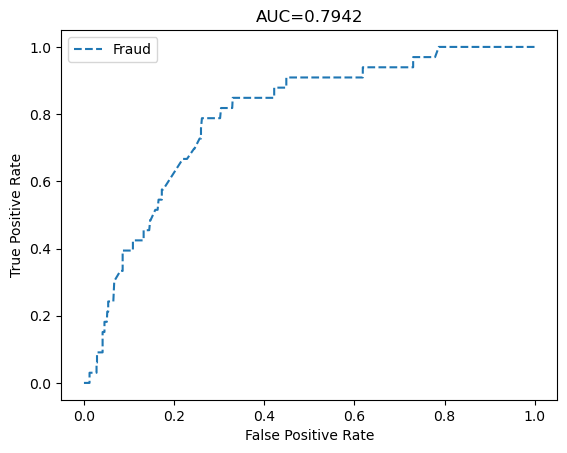

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

pyplot.plot(fpr, tpr, linestyle='--', label='Fraud')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title(f'AUC={auc:.4f}')
pyplot.legend()
pyplot.show()

다음 모듈에서 재사용할 변수들을 저장합니다. 만약 다음 모듈로 진행하지 않는다면 아래 섹션의 코드 셀을 주석 해제 후 실행해 주세요.

In [47]:
%store endpoint_name test_df s3_path

Stored 'endpoint_name' (str)
Stored 'test_df' (DataFrame)


UsageError: Unknown variable 's3_path'


### (Optional) Endpoint Clean-up

In [ ]:
# xgb_predictor.delete_endpoint()
# xgb_model.delete_model()